# *lsforce* example script: Full parameterization
---

This example script produces the force-time function and associated trajectory for a very large ice–rock avalanche occurring on Iliamna Volcano, Alaska, USA, on 22 May 2016 (Toney et al., in review). Here, we use the "full" model vector parameterization method, which imposes no constraints on the form of the force-time function. This example demonstrates how to use the built-in jackknife method to assess inversion stability under changing input data.

**References**

Toney, L., Fee, D., Allstadt, K. E., Haney, M., & Matoza, R. S. (in review). Reconstructing the dynamics of the highly-similar May 2016 and June 2019 Iliamna Volcano, Alaska ice–rock avalanches from seismoacoustic data. *Earth Surface Dynamics Discussions*, 1–32. https://doi.org/10.5194/esurf-2020-47

### Import necessary modules

In [1]:
from pathlib import Path

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth

from lsforce import LSData, LSForce, LSTrajectory

# Ignore benign Matplotlib backend warning due to fig.show()
import warnings
warnings.filterwarnings(action='ignore', message='Matplotlib is currently using module')

### Define some constants, set up folder structure

In [2]:
PERIOD_RANGE = (15, 80)  # [s] Bandpass filter corners

LS_LAT, LS_LON = (60.0273, -153.0683)  # Where the point force will be applied
ORIGIN_TIME = UTCDateTime(2016, 5, 22, 7, 57, 34)

STARTTIME = ORIGIN_TIME - 100
ENDTIME = ORIGIN_TIME + 300

# Set up folder structure
main_folder = Path.cwd() / 'iliamna_2016_paper'
if not main_folder.exists():
    main_folder.mkdir()

### Gather inversion waveforms

TA.N19K..BHE -> TA.N19K..BHE
{'azimuth': 90.1, 'dip': 0.0}
Not equal to tolerance rtol=1e-07, atol=0
Mismatched elements: 16001 / 16001 (100%)
Max absolute difference: 2.0768844012104353
Max relative difference: 1.9303316495966296
 x: array([ 13.493983,  11.495731,  11.497477, ...,  80.41185 ,  79.406616,
        78.399636])
 y: array([12, 10, 10, ..., 79, 78, 77], dtype=int32)

TA.N19K..BHN -> TA.N19K..BHN
{'azimuth': 0.1, 'dip': 0.0}
Not equal to tolerance rtol=1e-07, atol=0
Mismatched elements: 16001 / 16001 (100%)
Max absolute difference: 0.9723503413315484
Max relative difference: 0.0016166030670958715
 x: array([ 855.977752,  856.981241,  857.98124 , ...,  808.860887,
        805.862637,  801.864388])
 y: array([856, 857, 858, ..., 809, 806, 802], dtype=int32)

ZE.WFLW..HHE -> ZE.WFLW..HHE
{'azimuth': 90.0, 'dip': 0.0}
Not equal to tolerance rtol=1e-07, atol=0
(shapes (39999,), (40000,) mismatch)
 x: array([ 587.,  589.,  588., ...,  583.,  589.,  576.])
 y: array([588, 587, 589,

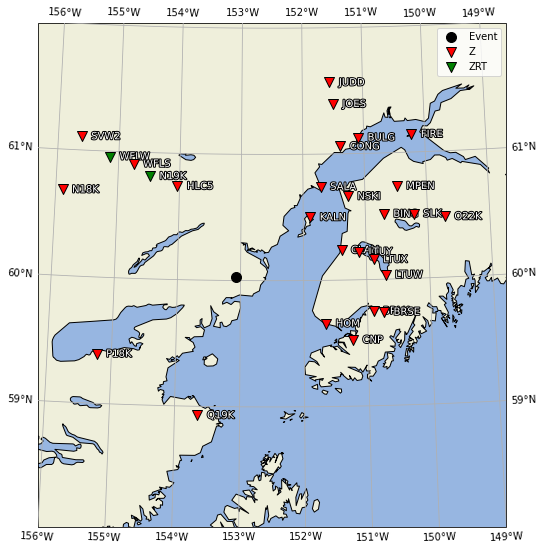

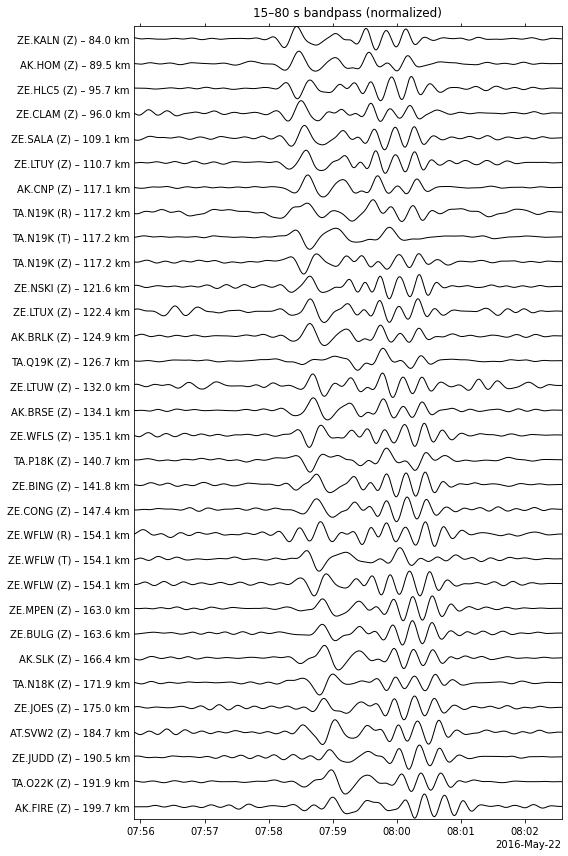

In [3]:
TONEY_ET_AL_NUM_CHANS = 32  # Number of channels used in paper's 2016 Iliamna inversion

data_filename = main_folder / 'data.pkl'

# Download data if it doesn't exist as a file
if not data_filename.exists():

    client = Client('IRIS')
    waveform_kwargs = dict(
        location='*', starttime=STARTTIME, endtime=ENDTIME, attach_response=True
    )

    # Gather vertical components (most of the waveforms!)
    NETWORKS = (
        'AK',
        'AT',
        'AV',
        'TA',
        'ZE',
    )
    STATIONS = (
        'KALN',
        'HOM',
        'HLC5',
        'CLAM',
        'SALA',
        'LTUY',
        'N19K',
        'CNP',
        'NSKI',
        'LTUX',
        'BRLK',
        'Q19K',
        'LTUW',
        'BRSE',
        'WFLS',
        'P18K',
        'BING',
        'CONG',
        'WFLW',
        'MPEN',
        'BULG',
        'SLK',
        'N18K',
        'JOES',
        'SVW2',
        'JUDD',
        'O22K',
        'FIRE',
    )
    st = client.get_waveforms(
        network=','.join(NETWORKS),
        station=','.join(STATIONS),
        channel='BHZ,HHZ',
        **waveform_kwargs,
    )

    # Gather horizontals (only a few)
    st += client.get_waveforms(
        network='TA', station='N19K', channel='BHE,BHN', **waveform_kwargs
    )
    st += client.get_waveforms(
        network='ZE', station='WFLW', channel='HHE,HHN', **waveform_kwargs
    )

    # Grab coordinates
    inv = client.get_stations(
        network=','.join(NETWORKS),
        starttime=STARTTIME,
        endtime=ENDTIME,
        level='channel',
    )

    # Assign coordinates to Traces
    for tr in st:
        coords = inv.get_coordinates(tr.id, datetime=STARTTIME)
        tr.stats.latitude = coords['latitude']
        tr.stats.longitude = coords['longitude']

    st.write(str(data_filename), format='PICKLE')

# Use file if it exists, for speed
else:
    st = read(str(data_filename), format='PICKLE')

# Verify that the correct number of channels has been retrieved from IRIS
assert st.count() == TONEY_ET_AL_NUM_CHANS, 'Not the correct number of channels.'

# Create LSData object
data = LSData(st, source_lat=LS_LAT, source_lon=LS_LON)

# Create plots
data.plot_stations(label_stations=True);
data.plot_data(equal_scale=False, period_range=PERIOD_RANGE);

### Gather reference waveforms

In [4]:
RAYLEIGH_VELO = 0.9  # [km/s] Surface-wave group velocity @ 1 Hz
INFRA_VELO = 0.337  # [km/s] Reasonable given air temp of 50 degrees F

client = Client('IRIS')

# Gather seismic
st_hf = client.get_waveforms(
    network='AV',
    station='ILSW',
    location='--',
    channel='BHZ',
    starttime=STARTTIME,
    endtime=ENDTIME,
    attach_response=True,
)
# Gather infrasound
st_infra = client.get_waveforms(
    network='TA',
    station='O20K',
    location='*',
    channel='BDF',
    starttime=STARTTIME,
    endtime=ENDTIME,
    attach_response=True,
)

# Combined processing
(st_hf + st_infra).remove_response()
(st_hf + st_infra).detrend('demean')
(st_hf + st_infra).taper(max_percentage=0.05)

# Separate filtering
st_hf.filter('bandpass', freqmin=0.5, freqmax=5)
st_infra.filter('bandpass', freqmin=0.5, freqmax=10)

# Add "distance" to tr.stats
ref_inv = client.get_stations(
    network='AV,TA',
    station='ILSW,O20K',
    starttime=STARTTIME,
    endtime=ENDTIME,
    level='channel',
)

for tr in st_hf + st_infra:
    coords = ref_inv.get_coordinates(tr.id, datetime=STARTTIME)
    tr.stats.latitude = coords['latitude']
    tr.stats.longitude = coords['longitude']
    dist = gps2dist_azimuth(LS_LAT, LS_LON, tr.stats.latitude, tr.stats.longitude)[0]
    tr.stats.distance = dist / 1000  # [km]

# Approximate correction for travel time
hf_shift = st_hf[0].stats.distance / RAYLEIGH_VELO
infra_shift = st_infra[0].stats.distance / INFRA_VELO

/Users/ltoney/opt/miniconda3/envs/lsforce/lib/python3.7/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (10) of bandpass is at or above Nyquist (10.0). Applying a high-pass instead.
  warnings.warn(msg)


### Setup

In [5]:
force = LSForce(data=data, data_sampling_rate=1, main_folder=main_folder)

force.setup(period_range=PERIOD_RANGE, zerophase=True, syngine_model='iasp91_2s')

Resampled records are of differing lengths. Interpolating all records to same start time and sampling rate.
Getting Green's functions...
Downloaded BING (1/28)
Downloaded BRLK (2/28)
Downloaded BRSE (3/28)
Downloaded BULG (4/28)
Downloaded CLAM (5/28)
Downloaded CNP (6/28)
Downloaded CONG (7/28)
Downloaded FIRE (8/28)
Downloaded HLC5 (9/28)
Downloaded HOM (10/28)
Downloaded JOES (11/28)
Downloaded JUDD (12/28)
Downloaded KALN (13/28)
Downloaded LTUW (14/28)
Downloaded LTUX (15/28)
Downloaded LTUY (16/28)
Downloaded MPEN (17/28)
Downloaded N18K (18/28)
Downloaded N19K (19/28)
Downloaded NSKI (20/28)
Downloaded O22K (21/28)
Downloaded P18K (22/28)
Downloaded Q19K (23/28)
Downloaded SALA (24/28)
Downloaded SLK (25/28)
Downloaded SVW2 (26/28)
Downloaded WFLS (27/28)
Downloaded WFLW (28/28)


### Invert

In [6]:
force.invert(
    zero_time=122,
    impose_zero_start=True,
    add_to_zero=True,
    jackknife=True,
    num_iter=20,
    frac_delete=0.3,
    alpha=4.8e-17,
    zero_scaler=5,
    tikhonov_ratios=(0.4, 0.0, 0.6),
)

Variance reduction = 83.688168 percent
Jackknife VR stats: max 85, min 81, median 83


### Plot inversion

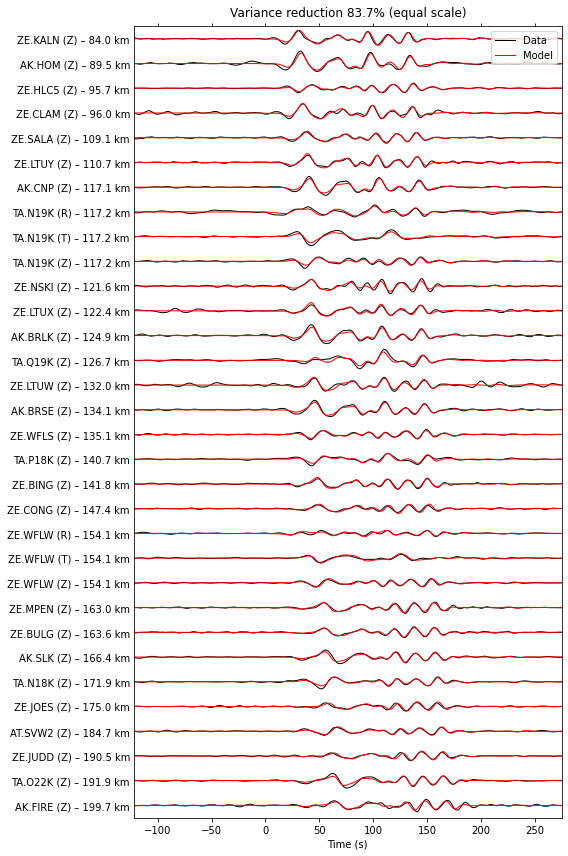

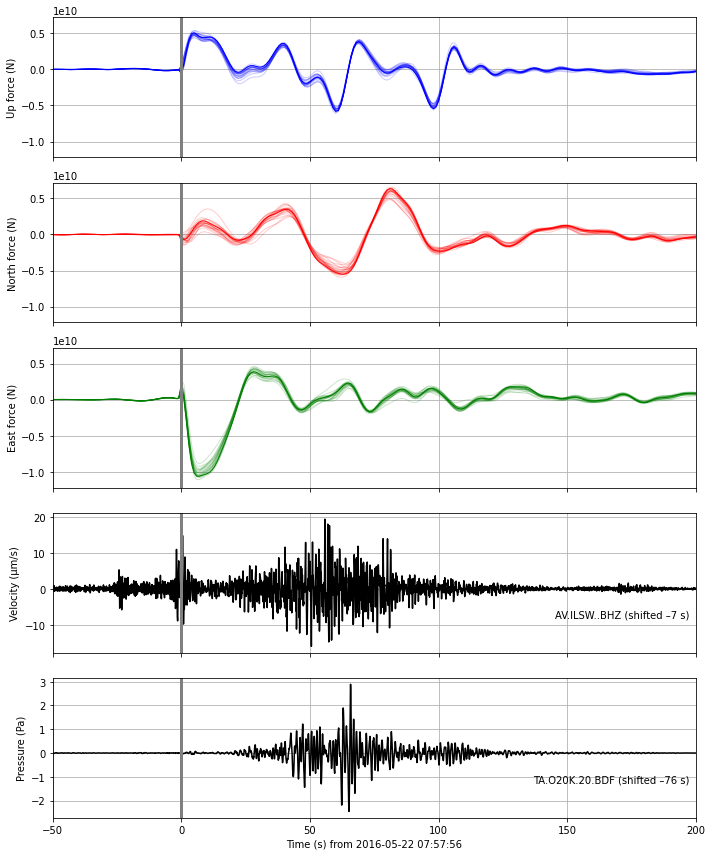

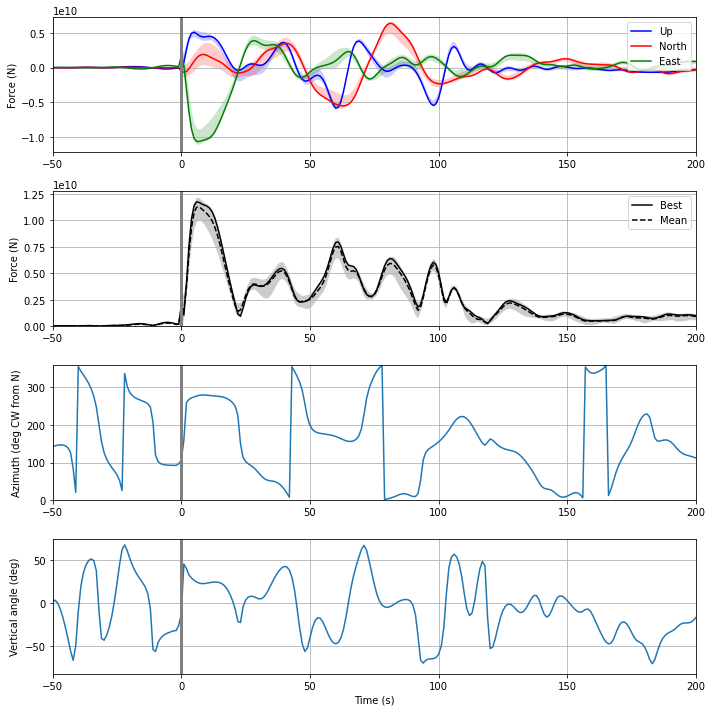

In [7]:
XLIM = (-50, 200)  # [s] x-axis (time) limits for plots

# Plot inversion waveform fits and results
force.plot_fits();
force.plot_forces(
    highf_tr=st_hf[0],
    hfshift=hf_shift,
    infra_tr=st_infra[0],
    infra_shift=infra_shift,
    jackshowall=True,
    xlim=XLIM,
    subplots=True,
);
force.plot_angle_magnitude(xlim=XLIM);

### Compute trajectory

In [8]:
L = 5.8  # [km] Estimate of horizontal COM runout length

trajectory = LSTrajectory(
    force, target_length=L, duration=XLIM[1], detrend_velocity=XLIM[1]
)

### Plot trajectory

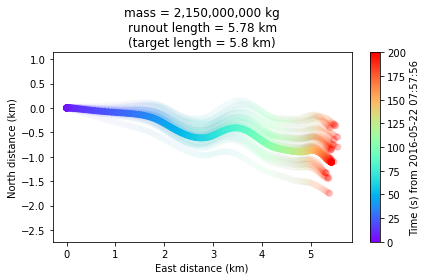

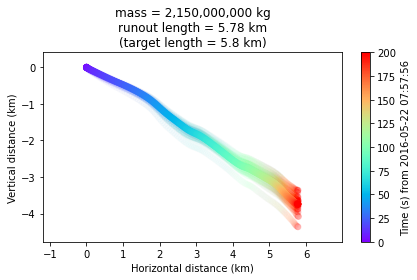

In [9]:
trajectory.plot_trajectory(plot_jackknife=True);
trajectory.plot_trajectory(plot_jackknife=True, elevation_profile=True);